In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def save_checkpoint(model, filename):
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
        'history': model.history,
    }

    # Extract the final classifier and the state dictionary for resnet-18
    checkpoint['fc'] = model.fc
    checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer if there is one
    if model.optimizer:
        checkpoint['optimizer'] = model.optimizer
        checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, filename)

In [3]:
def load_checkpoint(filename):
    # Load in checkpoint
    checkpoint = torch.load(filename)

    model = models.resnet18(pretrained=True)
    model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']
    model.history = checkpoint['history']

    return model

## Create ResNet18

In [4]:
# In order to use data from google drive, the drive must be mounted
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
root_folder = r"/content/gdrive/MyDrive/project"
!ls {root_folder}

 Attack_Defend.ipynb		        ifgsm_4_adv.npy
 Attack_v_Adversarial.ipynb	        ifgsm_4_def2.npy
 Attack_v_NoDefend.ipynb	        ifgsm_4_def.npy
 bigsm_def2.npy			        ifgsm_4.npy
 bigsm_def.npy			        ifgsm_6_def2.npy
 bigsm.npy			        ifgsm_6_def.npy
 caltech-resnet18-adversarialFGSM.pth   ifgsm_6.npy
 caltech-resnet18-trained.pth	        ifgsm_8_def2.npy
 Create_ResNet18_Adversarial.ipynb      ifgsm_8_def.npy
 create_resnet18.ipynb		        ifgsm_8.npy
 data				        mom_10.npy
 data.zip			        mom_2.npy
'Defense Test.ipynb'		        mom_4.npy
 fgsm_adv.npy			        mom_6.npy
 fgsm_def2.npy			        mom_8.npy
 fgsm_def.npy			        random-resizing-results.txt
 fgsm.npy			        test_fgsm_adv.npy
 ifgsm_10_def2.npy		        test_fgsm_def.npy
 ifgsm_10_def.npy		        test_fgsm.npy
 ifgsm_10.npy			        test_ifgsm_6_adv.npy
 ifgsm_2_adv.npy		        test_ifgsm_6.npy
 ifgsm_2_def2.npy		        test_mom_6_adv.npy
 ifgsm_2_def.npy		        test_mom_6.npy
 ifgsm_2.

## Train ResNet18 with adverserial data

In [6]:
from torchvision import datasets, models, transforms
from torch import cuda, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import time

In [7]:
# THIS CODE RUNS THE FGSM ATTACK
class FGSMAttack:
    # model - attack model for getting gradients
    # model_norm - ImageNet normalisation for running model with
    # epsilon - amount to perturb each time - default 1 pixel value step
    def __init__(self, model, model_norm, epsilon=1):
        self._model = model
        self._model_norm = model_norm
        self._epsilon = epsilon/255  # scale pixel value to tensor range
        
    # image as a tensor - range [0,1]
    # target as a tensor
    def attack_image(self, image, target):
        # ImageNet normalisation
        norm_image = self._model_norm(image.squeeze()).unsqueeze(0)
        
        # Forward pass the data through the model
        norm_image.requires_grad = True
        output = self._model(norm_image)
            
        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        self._model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = norm_image.grad.data

        # Call FGSM Attack
        return self.fgsm_attack(image, data_grad)

    # FGSM attack code
    def fgsm_attack(self, image, data_grad):
        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.sign()
        # Create the perturbed image by adjusting each pixel of the input image
        perturbed_image = image + self._epsilon*sign_data_grad
        # Adding clipping to maintain range [0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        # Return the perturbed image
        return perturbed_image

In [13]:
class TrainModel:
    
    def __init__(self, model, loss_function, optimizer,
                 training_data, validating_data, device, model_norm, epsilon = 16):
        self._model = model
        self._loss_function = loss_function
        self._optimizer = optimizer
        self._training_data = training_data
        self._validating_data = validating_data
        self._device = device
        self._model_norm = model_norm
        self._attack = FGSMAttack(self._model, self._model_norm, epsilon)
        
    def train(self, save_file_name='checkpoint.pth',
              max_epochs_notimproving=1, 
              max_lr_decrease=3,
              n_epochs=20):
        
        epoch0 = self._model.epochs
        print(f'Model has been trained for: {epoch0} epochs already.\n')
        history = self._model.history
        history['training_loss_adv'] = []
        history['training_acc_adv'] = []
        history['training_top5_adv'] = []
        history['validate_loss_adv'] = []
        history['validate_acc_adv'] = []
        history['validate_top5_adv'] = []
    
        # early stopping tracking
        epochs_not_improved = 0
        validate_loss_min = float("inf")
        best_epoch = -1
        lr_decrease = 0
        
        # Decay learning rate by a factor of 0.1 every 1 step (when the validation set no longer improves)
        scheduler = lr_scheduler.StepLR(self._optimizer, step_size=1, gamma=0.1)
    
        starting_time = time.time()
        epoch = 0
        while epoch < n_epochs and lr_decrease <= max_lr_decrease:
            print(f'\n Starting epoch {epoch++epoch0}')
            print('-'*10)
        
            training_loss, training_acc, training_top5, training_loss_adv, training_acc_adv, training_top5_adv = self.train_model_epoch(starting_time)    
            validate_loss, validate_acc, validate_top5, validate_loss_adv, validate_acc_adv, validate_top5_adv = self.validate_model_epoch(starting_time)
            
            self._model.epochs += 1
        
            # store history
            history['training_loss'].append(training_loss / len(self._training_data.dataset))
            history['validate_loss'].append(validate_loss / len(self._validating_data.dataset))
            history['training_acc'].append(training_acc / len(self._training_data.dataset))
            history['validate_acc'].append(validate_acc / len(self._validating_data.dataset))
            history['training_top5'].append(training_top5 / len(self._training_data.dataset))
            history['validate_top5'].append(validate_top5 / len(self._validating_data.dataset))

            history['training_loss_adv'].append(training_loss_adv / len(self._training_data.dataset))
            history['validate_loss_adv'].append(validate_loss_adv / len(self._validating_data.dataset))
            history['training_acc_adv'].append(training_acc_adv / len(self._training_data.dataset))
            history['validate_acc_adv'].append(validate_acc_adv / len(self._validating_data.dataset))
            history['training_top5_adv'].append(training_top5_adv / len(self._training_data.dataset))
            history['validate_top5_adv'].append(validate_top5_adv / len(self._validating_data.dataset))

            history['training_time'].append(time.time() - starting_time)
            history['lrate'].append(self._optimizer.param_groups[0]['lr'])
        
            print(f'Loss (Clean): Training ({history["training_loss"][epoch0+epoch]:.5f}) / Validate ({history["validate_loss"][epoch0+epoch]:.5f})')
            print(f'Accuracy (Clean): Training ({history["training_acc"][epoch0+epoch]:.5f}) / Validate ({history["validate_acc"][epoch0+epoch]:.5f})')
            print(f'Top5 (Clean): Training ({history["training_top5"][epoch0+epoch]:.5f}) / Validate ({history["validate_top5"][epoch0+epoch]:.5f})')

            print(f'Loss (Adv.): Training ({history["training_loss_adv"][epoch]:.5f}) / Validate ({history["validate_loss_adv"][epoch]:.5f})')
            print(f'Accuracy (Adv.): Training ({history["training_acc_adv"][epoch]:.5f}) / Validate ({history["validate_acc_adv"][epoch]:.5f})')
            print(f'Top5 (Adv.): Training ({history["training_top5_adv"][epoch]:.5f}) / Validate ({history["validate_top5_adv"][epoch]:.5f})')
        
            # early stopping
            if validate_loss < validate_loss_min:
                # validation loss decreased from last epoch
                self.store_checkpoint_model(save_file_name)
            
                epochs_not_improved = 0
                validate_loss_min = validate_loss
                best_epoch = epoch
            else:
                epochs_not_improved += 1
                if epochs_not_improved >= max_epochs_notimproving:
                
                    print(f'Breaking - {epochs_not_improved} / {max_epochs_notimproving} / {validate_loss} / {validate_loss_min}')
                    print(f'Early stopping at epoch {epoch}.')
                
                    self._model = self.load_checkpoint_model(save_file_name)
                                
                    training_loss = history['training_loss'][best_epoch+epoch0]
                    training_acc  = history['training_acc'][best_epoch+epoch0]
                    training_top5 = history['training_top5'][best_epoch+epoch0]
                    validate_loss = history['validate_loss'][best_epoch+epoch0]
                    validate_acc  = history['validate_acc'][best_epoch+epoch0]
                    validate_top5 = history['validate_top5'][best_epoch+epoch0]

                    training_loss_adv = history['training_loss_adv'][best_epoch]
                    training_acc_adv  = history['training_acc_adv'][best_epoch]
                    training_top5_adv = history['training_top5_adv'][best_epoch]
                    validate_loss_adv = history['validate_loss_adv'][best_epoch]
                    validate_acc_adv  = history['validate_acc_adv'][best_epoch]
                    validate_top5_adv = history['validate_top5_adv'][best_epoch]
                
                    print('*'*10)
                    print(f'Stepping learning rate from {self._optimizer.param_groups[0]["lr"]}')
                    scheduler.step()
                    lr_decrease += 1
                    print(f'to {self._optimizer.param_groups[0]["lr"]}')
                    print()
                    epochs_not_improved = 0
            epoch += 1

        self._model.optimizer = self._optimizer
    
        if epochs_not_improved != 0 and best_epoch > -1:
            print(f'Loading best_epoch to return.')
        
            self._model = self.load_checkpoint_model(save_file_name)
    
        total_time = time.time() - starting_time
        print(f'Ending... {total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')
        print(f'Best epoch: {best_epoch+epoch0} with loss: {history["validate_loss"][best_epoch+epoch0]:.2f} and acc: {100 * history["validate_acc"][best_epoch+epoch0]:.2f}%')
        print(f'Top5: Validate ({history["validate_top5"][best_epoch+epoch0]:.2f})')
    
        return model, history

    
    def train_model_epoch(self, starting_time):
        training_loss, training_acc, training_top5 = 0, 0, 0
        training_loss_adv, training_acc_adv, training_top5_adv = 0, 0, 0
        
        self._model.train()
        i = 0
        for inputs, labels in self._training_data:
            inputs = inputs.to(self._device)
            labels = labels.to(self._device)
            inputs_adv = self._attack.attack_image(inputs, labels)


            norm_inputs = self._model_norm(inputs.squeeze())
            norm_inputs_adv = self._model_norm(inputs_adv.squeeze())
            
            self._optimizer.zero_grad() # clear previous update data
            outputs = self._model(norm_inputs.unsqueeze(0)) # predict
            loss = self._loss_function(outputs, labels) # determine loss
            loss.backward()  # backprop
            self._optimizer.step() # update model parameters
            
            training_loss += loss.item() * inputs.size(0) # mean loss for batch * items in batch
            
            _, predicted_classes = torch.max(outputs,1)
            training_acc += torch.sum(predicted_classes == labels.data).item()
            
            _, top5_classes = torch.topk(outputs,5)
            for r in range(labels.size(0)):
                correct = labels[r]
                if correct in top5_classes[r]:
                    training_top5 += 1
            
            self._optimizer.zero_grad() # clear previous update data
            outputs_adv = self._model(norm_inputs_adv.unsqueeze(0)) # predict
            loss_adv = self._loss_function(outputs_adv, labels) # determine loss
            loss_adv.backward()  # backprop
            self._optimizer.step() # update model parameters
            
            training_loss_adv += loss_adv.item() * inputs_adv.size(0) # mean loss for batch * items in batch
            
            _, predicted_classes_adv = torch.max(outputs_adv,1)
            training_acc_adv += torch.sum(predicted_classes_adv == labels.data).item()
            
            _, top5_classes_adv = torch.topk(outputs_adv,5)
            for r in range(labels.size(0)):
                correct_adv = labels[r]
                if correct_adv in top5_classes_adv[r]:
                    training_top5_adv += 1
            
            i += inputs.size(0)
            total_time = time.time() - starting_time
            print(f'Training... \t{100*i / len(training_data.dataset):.2f}% complete ({i}). {total_time:.2f} total seconds elapsed.', end='\r')
        print()

        return training_loss, training_acc, training_top5, training_loss_adv, training_acc_adv, training_top5_adv

    def validate_model_epoch(self, starting_time):
        validate_loss, validate_acc, validate_top5 = 0, 0, 0
        validate_loss_adv, validate_acc_adv, validate_top5_adv = 0, 0, 0
        
        i = 0
        self._model.eval()
        for inputs, labels in self._validating_data:
            inputs = inputs.to(self._device)
            labels = labels.to(self._device)
            inputs_adv = self.attack.attack_image(inputs, labels)
            
            with torch.no_grad():
                outputs = self._model(inputs) # predict
                loss = self._loss_function(outputs, labels) # determine loss
                
                validate_loss += loss.item() * inputs.size(0) # mean loss for batch * items in batch
            
                _, predicted_classes = torch.max(outputs,1)
                validate_acc += torch.sum(predicted_classes == labels.data).item()
                
                _, top5_classes = torch.topk(outputs,5)
                for r in range(labels.size(0)):
                    correct = labels[r]
                    if correct in top5_classes[r]:
                        validate_top5 += 1

                outputs_adv = self._model(inputs_adv) # predict
                loss_adv = self._loss_function(outputs_adv, labels) # determine loss
                
                validate_loss_adv += loss.item() * inputs.size(0) # mean loss for batch * items in batch
            
                _, predicted_classes_adv = torch.max(outputs_adv,1)
                validate_acc_adv += torch.sum(predicted_classes_adv == labels.data).item()
                
                _, top5_classes_adv = torch.topk(outputs_adv,5)
                for r in range(labels.size(0)):
                    correct_adv = labels[r]
                    if correct_adv in top5_classes_adv[r]:
                        validate_top5_adv += 1
                    
                i += inputs.size(0)
                total_time = time.time() - starting_time
                print(f'Validating... \t{100*i / len(self._validating_data.dataset):.2f}% complete ({i}).', end='\r')
        print()

        return validate_loss, validate_acc, validate_top5, validate_loss_adv, validate_acc_adv, validate_top5_adv
    
    def store_checkpoint_model(self, save_file_name):
        self._model.to('cpu')
        s = {'model_state_dict': self._model.state_dict()}
        torch.save(s, save_file_name)
        self._model.to(self._device)
        
    def load_checkpoint_model(self, save_file_name):
        best_epoch_state = torch.load(save_file_name)
        self._model.to('cpu') # ensure no GPU out of memory issues...
        self._model.load_state_dict(best_epoch_state['model_state_dict'])
        self._model.to(self._device)
        return self._model
    
    
def train_until(epochs, model, tr_data, va_data, norm_tx):
    if cuda.is_available():
        print('GPU detected, using cuda')
        device = 'cuda'
    else:
        print('NO GPU detected, using cpu')
        device = 'cpu'
    model.to(device)
    
    model.optimizer = optim.SGD(model.parameters(), weight_decay=0.0005, lr=0.001, momentum=0.9)
    
    train_model = TrainModel(model, 
                             nn.CrossEntropyLoss(), 
                             model.optimizer,
                             tr_data, 
                             va_data, 
                             device, norm_tx)
    
    model, hist = train_model.train(n_epochs=epochs)
    
    print(f'Finished training. Model has trained for a total of {model.epochs} epochs in total.')

    model.to('cpu')

    return model, hist

In [14]:
timg_tx = transforms.Compose([    
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
img_tx = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


batch_size = 1

training_imgs = datasets.ImageFolder(root=root_folder+"/data/train", transform=timg_tx)
training_data = DataLoader(training_imgs, batch_size=batch_size, shuffle=True)

validation_imgs = datasets.ImageFolder(root=root_folder+"/data/valid", transform=img_tx)
validation_data = DataLoader(validation_imgs, batch_size=batch_size, shuffle=True)

norm_tx = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
model = load_checkpoint(root_folder + r'/caltech-resnet18-trained.pth')
model, model.hist = train_until(
    100,
    model,
    training_data,
    validation_data,
    norm_tx
)
save_checkpoint(model, root_folder + r'/caltech-resnet18-adversarialFGSM2.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


GPU detected, using cuda
Model has been trained for: 16 epochs already.


 Starting epoch 16
----------


## Evaluate against Test

In [ ]:
def predict(model, data, loss_function):
    if cuda.is_available():
        print('GPU detected, using cuda')
        device = 'cuda'
    else:
        print('NO GPU detected, using cpu')
        device = 'cpu'
    model.to(device)
    
    validate_loss = 0
    validate_acc = 0
    validate_top5 = 0
    i = 0
    
    model.eval()
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)
            
        with torch.no_grad():
            outputs = model(inputs) # predict
            loss = loss_function(outputs, labels) # determine loss
                
            validate_loss += loss.item() * inputs.size(0) # mean loss for batch * items in batch
            
            _, predicted_classes = torch.max(outputs,1)
            validate_acc += torch.sum(predicted_classes == labels.data).item()
            
            _, top5_classes = torch.topk(outputs,5)
            for r in range(labels.size(0)):
                correct = labels[r]
                if correct in top5_classes[r]:
                    validate_top5 += 1

            i += inputs.size(0)
            print(f'Validating... \t{100*i / len(data.dataset):.2f}% complete ({i}).', end='\r')
    print()
    return validate_acc, validate_loss, validate_top5

In [ ]:
from matplotlib import pyplot as plt
def plot_model_graphs(h):
    max_loss = max(max(h['training_loss']),max(h['validate_loss']))
    plt.figure()
    plt.title(f'Loss over time ({len(h["training_time"])} epochs)')
    plt.plot((h['training_loss']),label='training')
    plt.plot((h['validate_loss']),label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss per image')
    plt.ylim(0,max_loss)
    plt.legend()

    plt.figure()
    plt.title(f'Accuracy over time ({len(h["training_time"])} epochs)')
    plt.plot(h['training_acc'],label='training')
    plt.plot(h['validate_acc'],label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim(0,1)
    plt.legend()

    plt.figure()
    plt.title(f'Top5 over time ({len(h["training_time"])} epochs)')
    plt.plot(h['training_top5'],label='training')
    plt.plot(h['validate_top5'],label='validation')
    plt.xlabel('epoch')
    plt.ylabel('In top5')
    plt.ylim(0,1)
    plt.legend()

In [ ]:
batch_size = 7

validation_imgs = datasets.ImageFolder(root=root_folder+"/data/valid", transform=img_tx)
validation_data = DataLoader(validation_imgs, batch_size=batch_size, shuffle=True)

test_imgs = datasets.ImageFolder(root=root_folder+"/data/valid", transform=img_tx)
test_data = DataLoader(test_imgs, batch_size=batch_size, shuffle=True)

GPU detected, using cuda
Validating... 	100.00% complete (878).
Validation accuracy: 0.9965831435079726
Validation loss: 0.02103090634727674
Validation top5 accuracy 1.0
GPU detected, using cuda
Validating... 	100.00% complete (878).
Test set accuracy: 0.9965831435079726
Test set loss 0.021030906549259147
test set Top5 accuracy 1.0


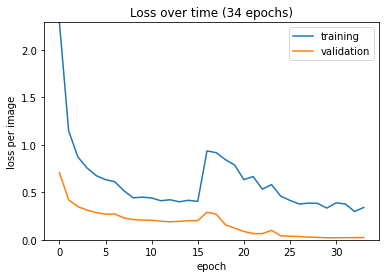

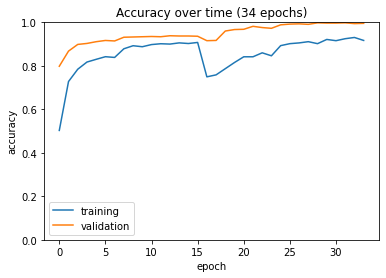

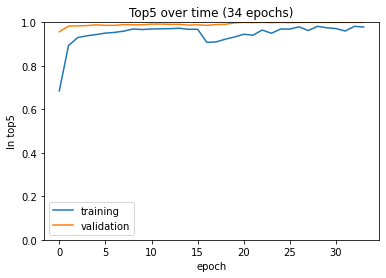

In [ ]:
model = load_checkpoint(root_folder + r'/caltech-resnet18-adversarialFGSM.pth')
plot_model_graphs(model.history)

v_acc, v_loss, v_top5 = predict(model, validation_data, nn.CrossEntropyLoss())
print("Validation accuracy:", v_acc / len(validation_imgs))
print("Validation loss:", v_loss/ len(validation_imgs))
print("Validation top5 accuracy", v_top5/ len(validation_imgs))

t_acc, t_loss, t_top5 = predict(model, test_data, nn.CrossEntropyLoss())
print("Test set accuracy:", t_acc / len(test_imgs))
print("Test set loss", t_loss / len(test_imgs))
print("test set Top5 accuracy", t_top5/ len(test_imgs))